In [39]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

In [40]:
data_src = "../birdclef-2022-data"
meta = pd.read_csv("../birdclef-2022-data/train_metadata.csv")
with open(f"{data_src}/scored_birds.json") as f:
    scored = json.load(f)

In [43]:
meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [68]:
ratings = meta.groupby("primary_label").mean()["rating"].reset_index().sort_values(by = "rating", ascending = False)
ratings["scored"] = ratings["primary_label"].isin(scored)

scored_meta = meta["primary_label"].isin(scored)
scored_meta = meta[scored_meta]

ratings_filtered = ratings['scored']==True
ratings_without_scored = ratings['scored']==False
# general info
information = f"""
total samples           {len(meta)}
total species           {len(meta['primary_label'].unique())}
scored species samples  {len(scored_meta)}
scored species          {len(scored)}

avg rating              {ratings[ratings_without_scored].rating.mean() :.2f}
avg rating scored       {ratings[ratings_filtered].rating.mean() :.2f}
"""

print(information)


total samples           14852
total species           152
scored class samples    1266
scored species          21

avg rating              3.71
avg rating scored       3.67



In [5]:
meta['secondary_labels'] = meta['secondary_labels'].apply(lambda x: re.findall(r"'(\w+)'", x))

Text(0, 0.5, '')

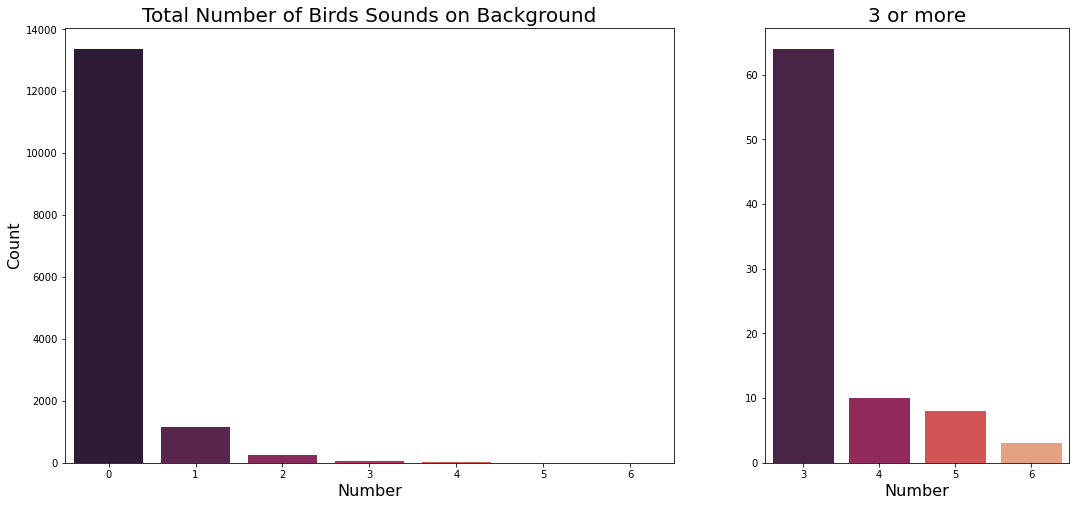

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8),gridspec_kw={'width_ratios': [2, 1]})
plot_temp = meta['secondary_labels'].apply(len).sort_values(ascending = False).reset_index()
sns.countplot(x = 'secondary_labels', data = plot_temp, palette = 'rocket', ax = ax[0])
sns.countplot(x = 'secondary_labels', data = plot_temp.query('secondary_labels > 2'), palette = 'rocket', ax = ax[1])

ax[0].set_title(f'Total Number of Birds Sounds on Background', fontdict = {'fontsize':20})
ax[1].set_title(f'3 or more', fontdict = {'fontsize':20})
ax[0].set_xlabel('Number', fontdict = {'fontsize':16})
ax[1].set_xlabel('Number', fontdict = {'fontsize':16})
ax[0].set_ylabel('Count', fontdict = {'fontsize':16})
ax[1].set_ylabel('')

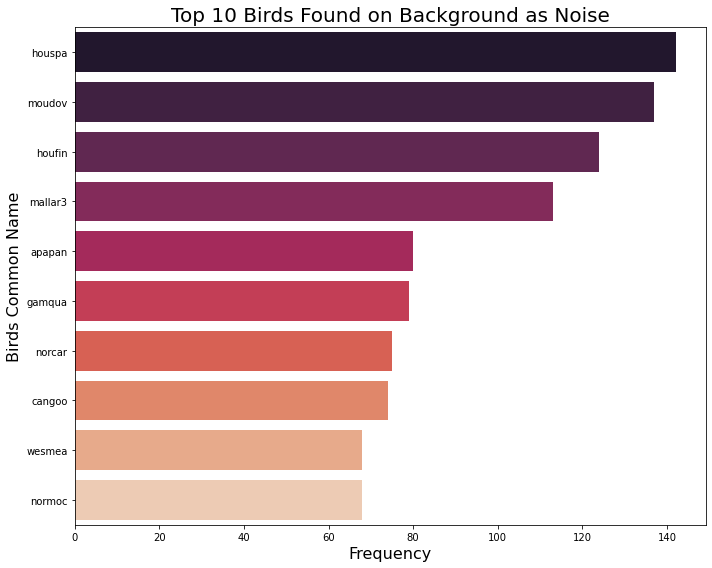

In [7]:
values = 10
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,8))
sns.barplot(y = 'index', x = 'secondary_labels', data = meta['secondary_labels'].explode().value_counts().head(values).reset_index(), ax = ax, palette = 'rocket')
ax.set_title(f'Top {values} Birds Found on Background as Noise', fontdict = {'fontsize':20})
ax.set_xlabel('Frequency', fontdict = {'fontsize':16})
ax.set_ylabel('Birds Common Name', fontdict = {'fontsize':16})


plt.tight_layout()

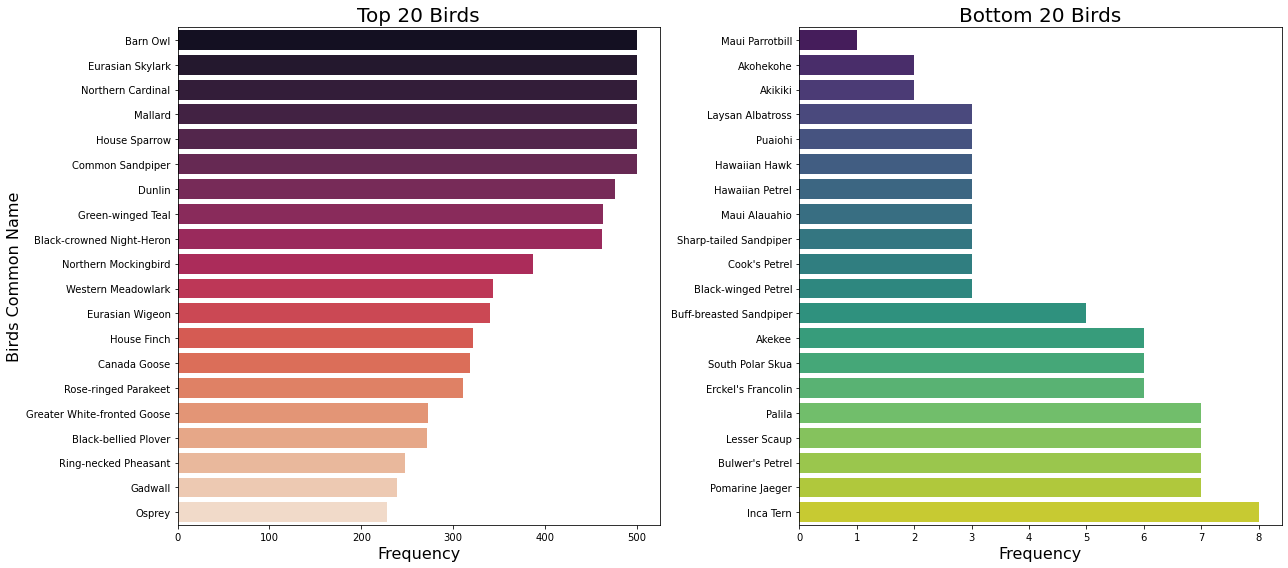

In [8]:
values = 20

top = meta['primary_label'].value_counts().head(values).index
bottom = meta['primary_label'].value_counts().tail(values).index

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,8))
sns.barplot(y = 'index', x = 'common_name', data = meta['common_name'].value_counts().head(values).reset_index(), ax = ax[0],palette = 'rocket')
sns.barplot(y = 'index', x = 'common_name', data = meta['common_name'].value_counts().tail(values).reset_index()[::-1], ax = ax[1], palette = 'viridis')
ax[0].set_title(f'Top {values} Birds', fontdict = {'fontsize':20})
ax[1].set_title(f'Bottom {values} Birds', fontdict = {'fontsize':20})
ax[0].set_xlabel('Frequency', fontdict = {'fontsize':16})
ax[1].set_xlabel('Frequency', fontdict = {'fontsize':16})
ax[0].set_ylabel('Birds Common Name', fontdict = {'fontsize':16})
ax[1].set_ylabel('')

plt.tight_layout()

In [9]:
def round_date(date, delta = 30, th = 10):
    date = date.to_pydatetime()
    x = date.minute
    if ((x >= (delta - th)) & (x < delta)) or (x > (delta + th)):
#         print('Up')
        date = date + (datetime.min - date) % timedelta(minutes = delta)
    elif ((x <= (delta+ th )) & (x > delta)) or (x < (delta - th)):
#         print('down')
        date = date - (date - datetime.min) % timedelta(minutes = delta)


    return date.time().strftime("%H:%M")

meta['time_tf']  = pd.to_datetime(meta['time'], errors = 'coerce').dropna().apply(lambda x:round_date(x))
meta.dropna(subset=['time_tf'], inplace = True)

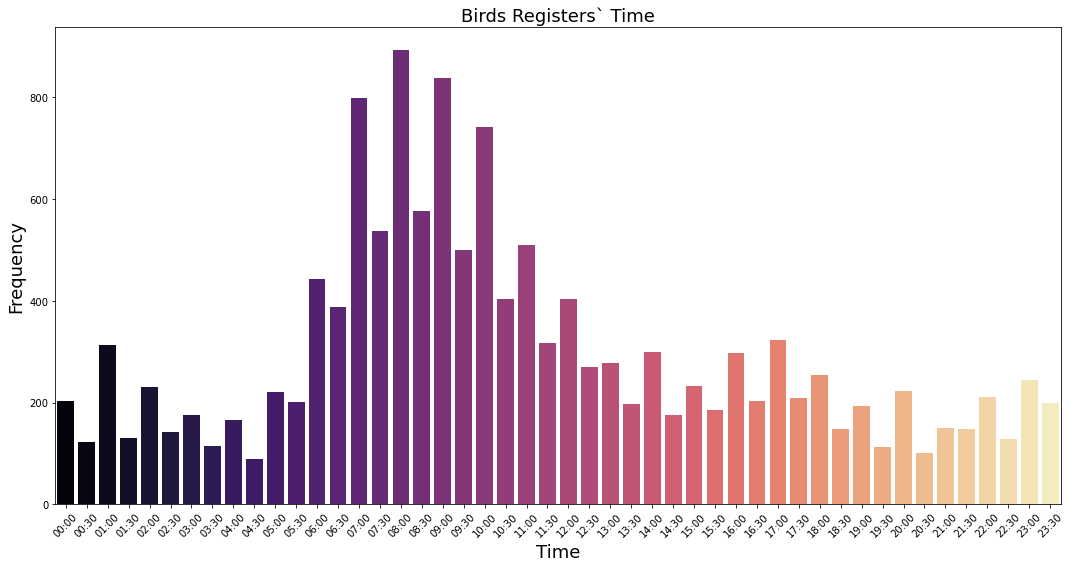

In [10]:
plt.figure(figsize = (15,8))
sns.countplot(x = 'time_tf', data = meta.sort_values(by = 'time_tf'), palette = 'magma')
plt.xticks(rotation=45)
plt.xlabel('Time', fontdict = {'fontsize':18})
plt.ylabel('Frequency', fontdict = {'fontsize':18})
plt.title('Birds Registers` Time',fontdict = {'fontsize':18})
plt.tight_layout()

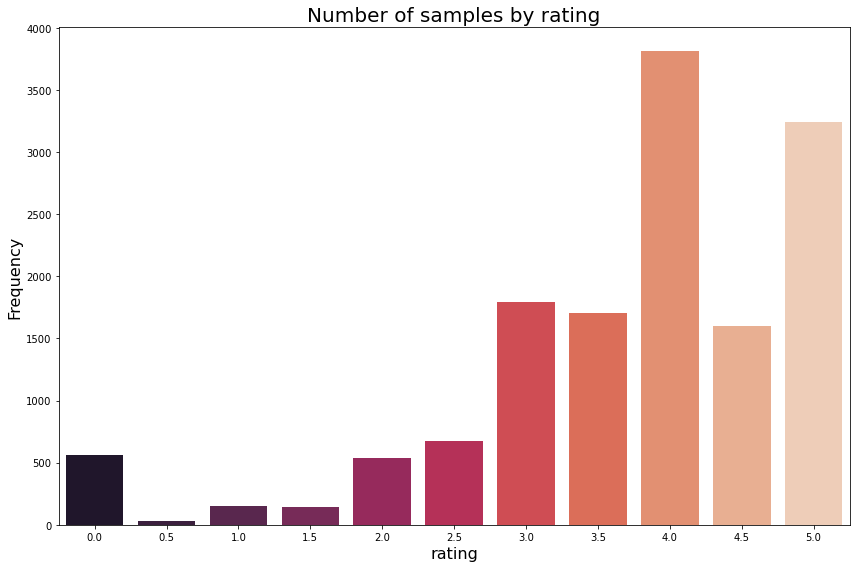

In [36]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,8))
sns.barplot(x = 'index', y = 'rating', data = meta['rating'].value_counts().sort_index(ascending = False).reset_index(), ax = ax, palette = 'rocket')
ax.set_title('Number of samples by rating', fontdict = {'fontsize':20})
ax.set_xlabel('rating', fontdict = {'fontsize':16})
ax.set_ylabel('Frequency', fontdict = {'fontsize':16})


plt.tight_layout()

In [37]:
print(meta['rating'].value_counts().sort_index(ascending = False).reset_index())

    index  rating
0     5.0    3238
1     4.5    1603
2     4.0    3812
3     3.5    1708
4     3.0    1790
5     2.5     676
6     2.0     537
7     1.5     142
8     1.0     148
9     0.5      30
10    0.0     565


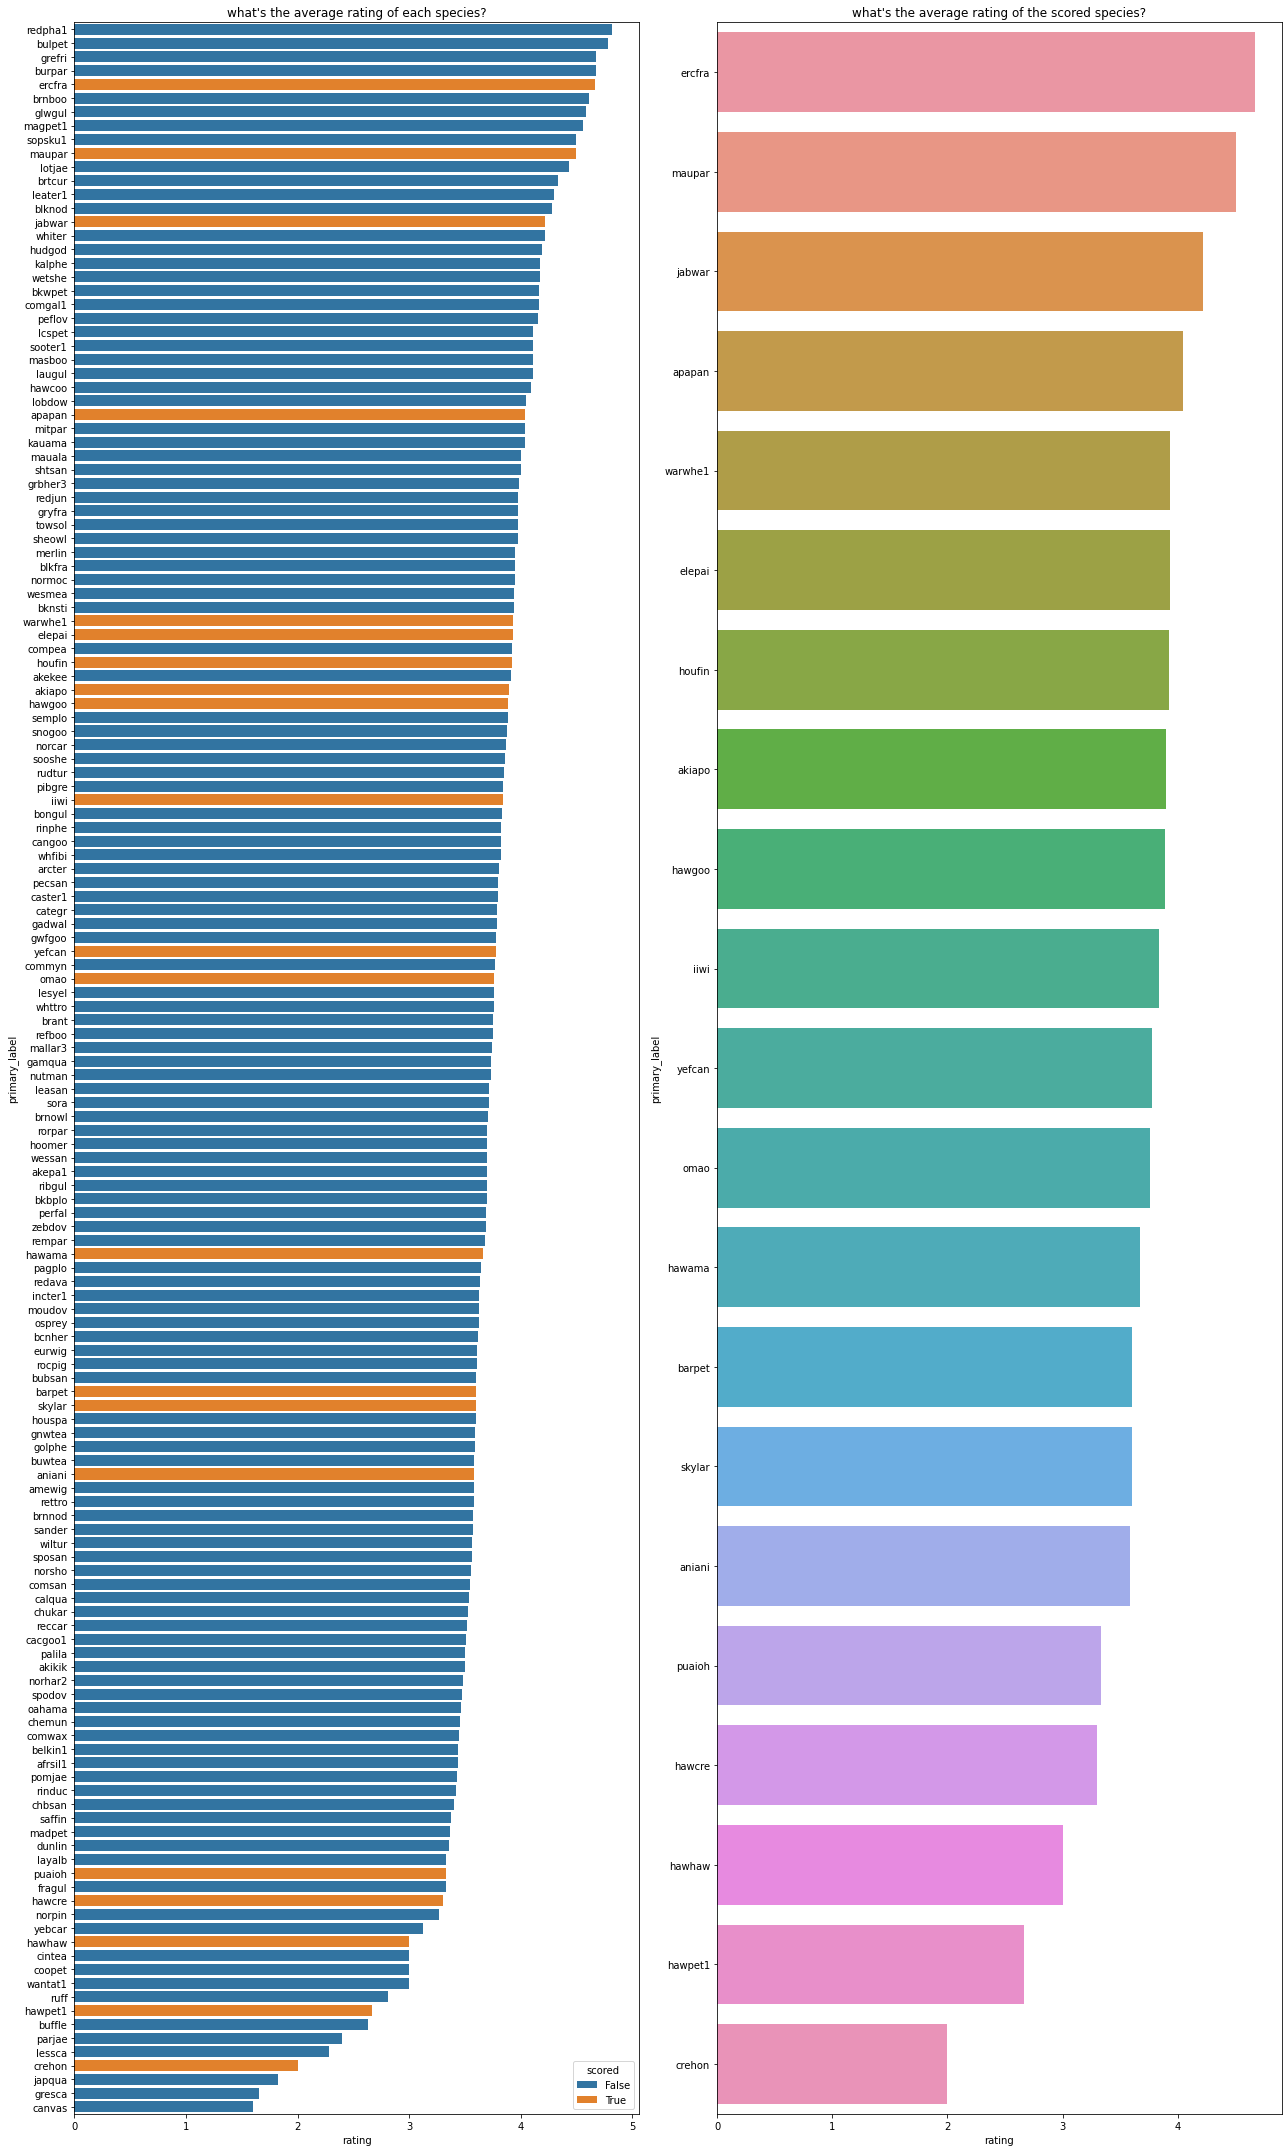

In [60]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,30))

ratings = meta.groupby("primary_label").mean()["rating"].reset_index().sort_values(by = "rating", ascending = False)
ratings["scored"] = ratings["primary_label"].isin(scored)
ratings_filtered = ratings['scored']==True
sns.barplot(data = ratings, y = "primary_label", x = "rating", ax = ax[0], dodge = False, hue = 'scored')
sns.barplot(data = ratings[ratings_filtered],y = "primary_label", x = "rating", ax = ax[1], dodge = False)
ax[0].set_title("what's the average rating of each species?")
ax[1].set_title("what's the average rating of the scored species?")
plt.tight_layout()

In [57]:
ratings = meta.groupby("primary_label").mean()["rating"].reset_index().sort_values(by = "rating", ascending = False)
ratings["scored"] = ratings["primary_label"].isin(scored)
ratings_filtered = ratings['scored']==True
filtered_result = ratings[ratings_filtered]

print(filtered_result.head(5))

    primary_label    rating  scored
47         ercfra  4.666667    True
90         maupar  4.500000    True
72         jabwar  4.217949    True
7          apapan  4.042553    True
141       warwhe1  3.929577    True
